<a href="https://colab.research.google.com/github/miguelmartinodoolmo/Bike_Demand_Estimation/blob/main/BikeDemandEstimation_Miguel_MartinodoOlmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike sharing demand prediction in Seoul


**Author: Miguel Martiño do Olmo**

**Master Thesis**

**MSc in Big Data and Data Science**

**Universidad Complutense de Madrid**

In this study, I investigate and forecast the hourly demand for bicycles in Seoul using a comprehensive approach and applying new techniques to a well known problem. By employing various supervised Machine Learning models, I demonstrate high predictive accuracy in determining bicycle demand patterns.

The dataset for this study, published by the Seoul Metropolitan Government, has been previously explored by other data scientists in public projects, as it was part of a Kaggle competition. My goal was to introduce novel techniques in data preprocessing, modeling, and deployment phases to push the boundaries of existing work. The outcome is a model that showcases exceptional predictive capabilities.

Throughout the study, I experimented with nine distinct models, including three Deep Learning approaches. Many of these models have not been previously documented with this dataset, apart from Linear Regression, which served as a benchmark for traditional techniques. **The most nobel aspect of this work is precisely the use of a convolutional neural network to predict the data, giving better results than many other models** (although not being the best).

In this study, I have also touched upon the use of Ngrok as a basis for deploying model interfaces. Although my exploration of this aspect is limited, the deployment of the final model directly from Google Colab serves as a preliminary example of how model interfaces could potentially be implemented in Development environment (to prepare for real-world applications) in a manner not commonly seen among other works.

This study formed an integral part of a Master's Thesis that was awarded with a score of 9.5 out of 10. The original work was written in Spanish, and the presented version has been translated with minor adaptations to make the content more practical and applicable, while still ensuring its relevance and comprehensibility.

# REQUIREMENTS


In [ ]:
# Requirements installation

%%capture
!pip install metpy
!pip install catboost
!pip install lightgbm
!pip install cubist
!pip install matplotlib==3.1.1
!pip install keras-tuner --upgrad
!pip install -U keras-tuner
!pip install pyngrok
!pip install flask-bootstrap
!pip install flask-ngrok

In [ ]:
# Import of libraries

# General
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy import stats
import seaborn as sns
import math

# Meteorology
import metpy
from metpy import calc
from metpy.units import units

# Preprocessing
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Models
from sklearn.linear_model import LinearRegression, SGDRegressor,HuberRegressor
import catboost as cb
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Deep Learning
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import keras_tuner
from keras_tuner.tuners import RandomSearch

# Metrics
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import explained_variance_score

# Productivization
import pickle 
from flask import Flask
from flask import Flask,request,jsonify,render_template
from pyngrok import ngrok
from flask_bootstrap import Bootstrap
from flask_ngrok import run_with_ngrok

# DATA INGESTION


The actual dataset can be found in UCI repository:

https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand

In [ ]:
# CSV Loading
data=pd.read_csv('SeoulBikeData.csv',encoding='unicode_escape')

In [ ]:
# We check the first 5 rows
data.head(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# We check the last 5 rows
data.tail(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [ ]:
# We check the size of the dataset
data.shape

(8760, 14)

In [ ]:
# We check the variables
list(data)

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons',
 'Holiday',
 'Functioning Day']

In [ ]:
# We check the type of variables
# As can be seen, there are 10 numerical variables (6 float and 4 int) and 4 categorical 

data.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Date                       object 
 1   Rented Bike Count          int64  
 2   Hour                       int64  
 3   Temperature(°C)            float64
 4   Humidity(%)                int64  
 5   Wind speed (m/s)           float64
 6   Visibility (10m)           int64  
 7   Dew point temperature(°C)  float64
 8   Solar Radiation (MJ/m2)    float64
 9   Rainfall(mm)               float64
 10  Snowfall (cm)              float64
 11  Seasons                    object 
 12  Holiday                    object 
 13  Functioning Day            object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


# EDA

### Univariate analysis



First, I check if there are any null fields, as in that case a transformation would be necessary, either by removing them or imputing values.

In [ ]:
# We check null fields
data.isna().sum().sort_values(ascending=False)

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

As we can see, there are no null fields.

Now, I will sum the total number of bicycles demanded in the year under consideration.

In [ ]:
# Total bycicles demanded
data['Rented Bike Count'].sum()

6172314

In [ ]:
# Statistics of target variable
data['Rented Bike Count'].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Rented Bike Count, dtype: float64

Above, we can see interesting statistical data for the target variable.

Since the mean is higher than the median (represented by the 50%), we can assume that the distribution has a positive skew, something we will verify. It is also evident that in the hours with the lowest demand, it can drop to 0, with an absolute maximum of 3,556. This fact aligns with a high standard deviation relative to the mean.

Next, I will compare the distribution with the normal distribution to corroborate these indications.

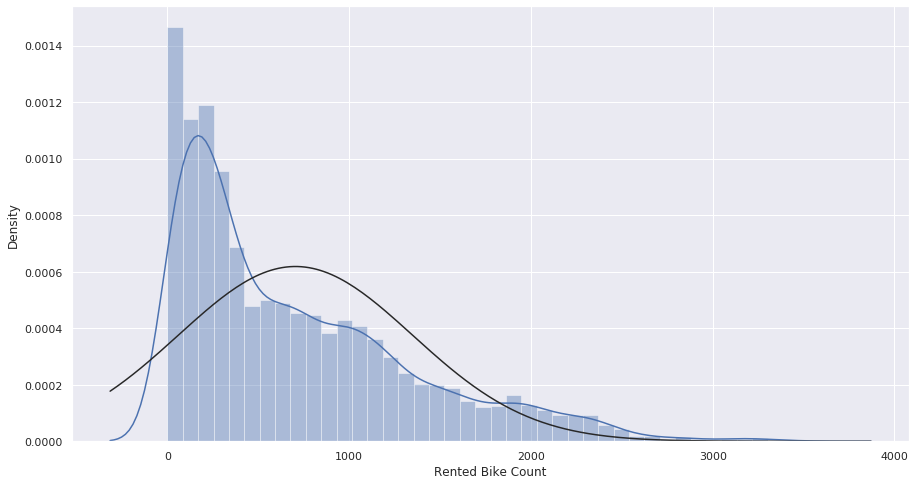

In [ ]:
# We compare the distribution of the target variable with the normal distribution
sns.set(rc={'figure.figsize':(15,8)})
sns.distplot(data['Rented Bike Count'],fit=norm)

In [ ]:
# We calculate skewness and kurtosis
print("La asimetría es: ",data['Rented Bike Count'].skew())
print("La curtosis es: ",data['Rented Bike Count'].kurtosis())

La asimetría es:  1.1534281773679014
La curtosis es:  0.8533869902003848


The graph above is conclusive; our distribution deviates significantly from the normal distribution.

The skewness is positive and greater than 1, effect that will be corrected later on. The kurtosis initially seems to be controlled (less than 1), although it will likely be affected by the transformations we apply to the target variable, so we will monitor it.

In [ ]:
# Correlations of the independent variables with the target variable
Correlations=data.corr().unstack().sort_values(ascending=False)['Rented Bike Count']
Correlations

Rented Bike Count            1.000000
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
Solar Radiation (MJ/m2)      0.261837
Visibility (10m)             0.199280
Wind speed (m/s)             0.121108
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
dtype: float64

As can be seen above, the most correlated variables with the target are temperature, hour, and dew point temperature. On the other end, we have humidity, snow, and rain, with negative correlations.

#### Numerical variables

To continue with the univariate analysis, we display the main statistical metrics of the numerical variables.

In [ ]:
data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


[Text(0.5, 1.0, 'Bikes rented per Hour.   95% CI')]

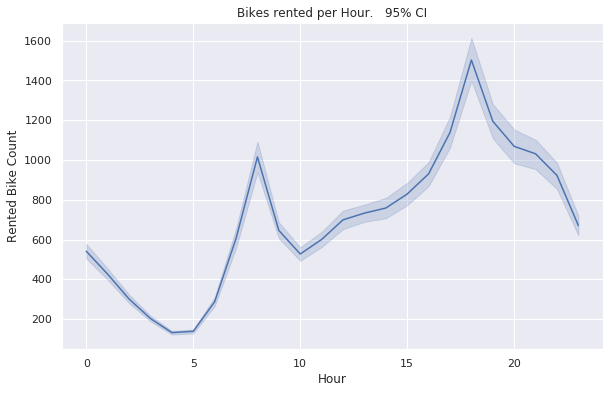

In [ ]:
# We analyze the bicycles rented per hour
# For the proportions of the graph, we choose the golden ratio, let's keep it classy
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='Hour',y='Rented Bike Count',ci=95).set(title='Bikes rented per Hour.   95% CI')

Above it can bee seen how the peak demand hours for bicycles are around 6:00 pm and to a lesser extent, 10:00 am. The lowest numbers occur during the early morning and around 10:00 am.

In [ ]:
# Rounded variables are created just for better interpretability of the graphics. To be removed later
data['TemperatureRound']=data['Temperature(°C)'].apply(np.round)
data['Dew point temperature Round']=data['Dew point temperature(°C)'].apply(np.round)
data['Solar Radiation (MJ/m2) Round']=data['Solar Radiation (MJ/m2)'].apply(np.round)
data['Rainfall(mm) Round']=data['Rainfall(mm)'].apply(np.round)
data['Snowfall (cm) Round']=data['Snowfall (cm)'].apply(np.round)
data['Visibility (10m) Round']=((data['Visibility (10m)']/100).apply(np.round))*100

[Text(0.5, 1.0, 'Bikes rented per Temperature  -  Rounded  -  CI 95%')]

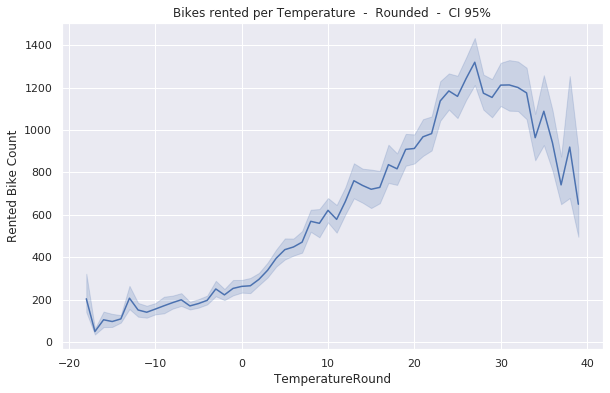

In [ ]:
# We check the number of rented bicycles based on the (rounded) temperature
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='TemperatureRound',y='Rented Bike Count',ci=95).set(title='Bikes rented per Temperature  -  Rounded  -  CI 95%')

Above, we can see that the highest demand for bicycles corresponds to a temperature around 25 and 35 degrees Celsius.

Below, it can be seen that this does not correspond to the most common temperatures, which are distributed more evenly with peaks around 20 and 2 degrees Celsius.

[Text(0.5, 1.0, 'Presence of the different temperatures in the dataset')]

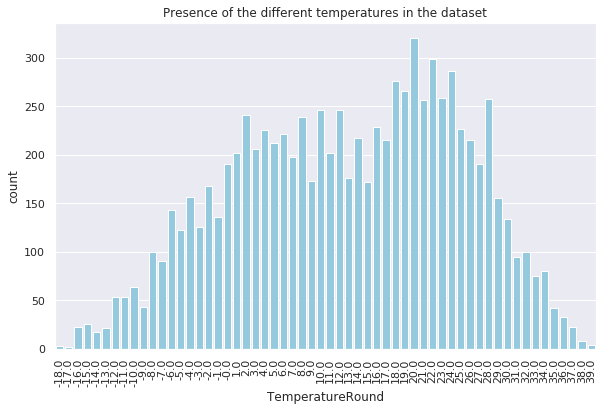

In [ ]:
plt.figure(figsize=(9.7,6))
plt.xticks(rotation = 90)
sns.countplot(x="TemperatureRound", data=data, color='skyblue').set(title='Presence of the different temperatures in the dataset')

[Text(0.5, 1.0, 'Bikes rented per Humidity (%)')]

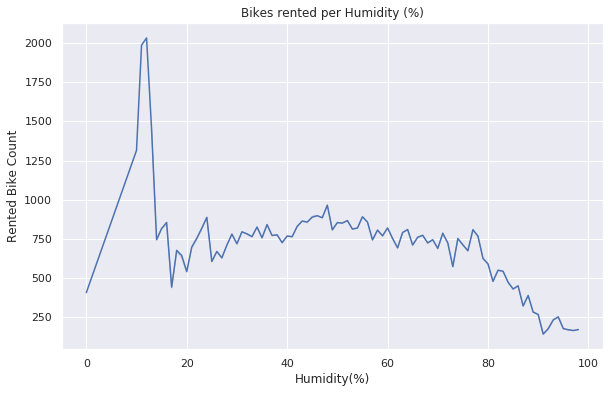

In [ ]:
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='Humidity(%)',y='Rented Bike Count',ci=False).set(title='Bikes rented per Humidity (%)')

Next, we compare the demand for bicycles with wind speed. It is observed (ignoring the probable outlier on the right, which we will study) that the highest demand is concentrated between 1.5 and 3.5 m/s wind speed, approximately.

[Text(0.5, 1.0, 'Bikes rented per Wind speed (m/s)  -  Rounded')]

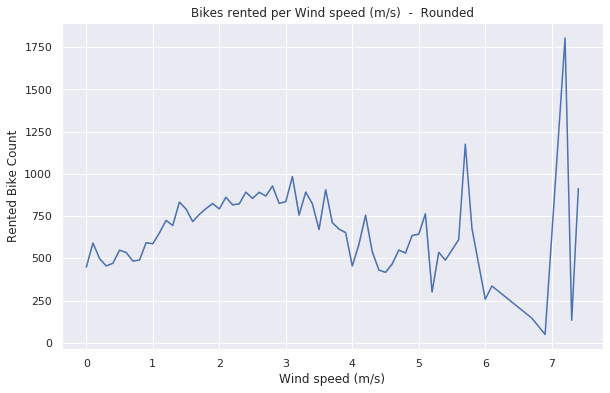

In [ ]:
# Relationship between wind speed and demand for bicycles
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='Wind speed (m/s)',y='Rented Bike Count',ci=False).set(title='Bikes rented per Wind speed (m/s)  -  Rounded')

Below, we compare the demand for bicycles with visibility.

It seems evident that as visibility increases, so does the demand (although I believe that both correlation and causality influence this fact). However, from 750 meters of visibility onwards, there are hardly any changes in demand.

[Text(0.5, 1.0, 'Bikes rented per Visibility (10m)  -  Rounded  -  CI 95%')]

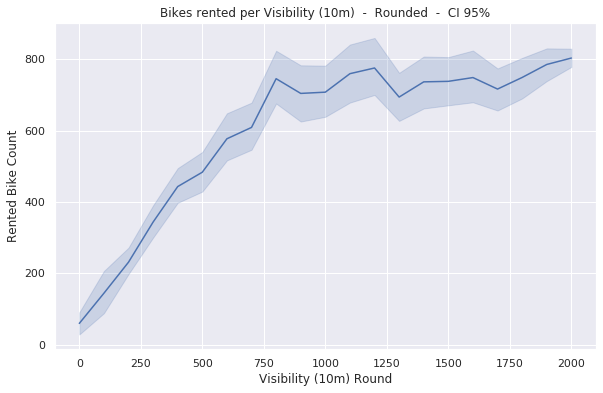

In [ ]:
# Relationship between visibility and demand for bicycles
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='Visibility (10m) Round',y='Rented Bike Count',ci=95).set(title='Bikes rented per Visibility (10m)  -  Rounded  -  CI 95%')

We perform the same test with the dew point temperature. Up to 10 degrees Celsius, the positive correlation with demand is clear, after which it becomes more uncertain.

[Text(0.5, 1.0, 'Bikes rented per Dew point temperature Round  -  Rounded  -  CI 95%')]

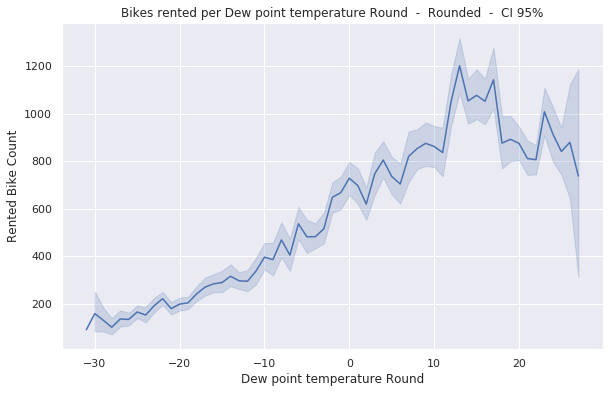

In [ ]:
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='Dew point temperature Round',y='Rented Bike Count',ci=95).set(title='Bikes rented per Dew point temperature Round  -  Rounded  -  CI 95%')

As it is one of the most influential variables along with time and temperature, we also analyze the distribution of the dew point temperature.:

[Text(0.5, 1.0, 'Presence of the different dew point temperatures in the dataset')]

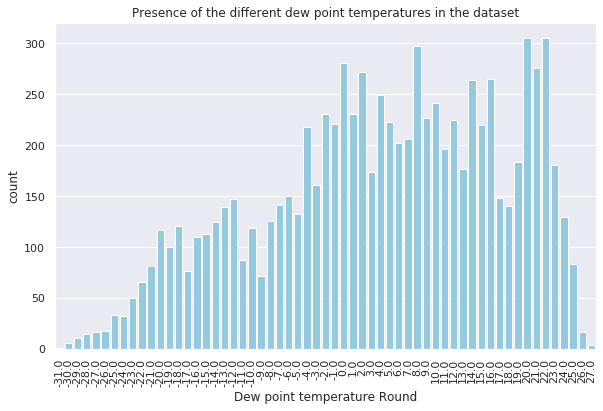

In [ ]:
plt.figure(figsize=(9.7,6))
plt.xticks(rotation = 90)
sns.countplot(x="Dew point temperature Round", data=data, color='skyblue').set(title='Presence of the different dew point temperatures in the dataset')

Below, we compare the demand for bicycles with solar radiation.

As we can see, there is a certain positive relationship, although there are many deviations (the graph with rounded variables, on the other hand, distorted the data, in my opinion).

[Text(0.5, 1.0, 'Bikes rented per Solar Radiation (MJ/m2)')]

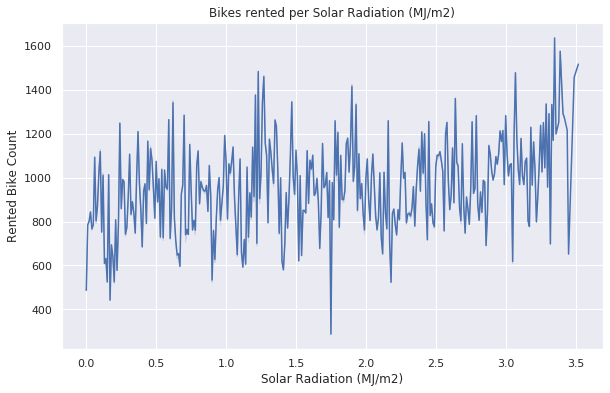

In [ ]:
# Not rounded because it distorts the graph too much.
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='Solar Radiation (MJ/m2)',y='Rented Bike Count',ci=False).set(title='Bikes rented per Solar Radiation (MJ/m2)')

We are comparing rainfall with demand. 

It can be seen that demand drops significantly if rainfall is greater than 0 (that is, if it rains even minimally). Therefore, once it rains, the negative correlation between rainfall intensity and demand would not be as strong. On the right side, we have some outliers that we will analyze later, but they do not seem to break the correlation.

[Text(0.5, 1.0, 'Bikes rented per Rainfall(mm) -  Rounded')]

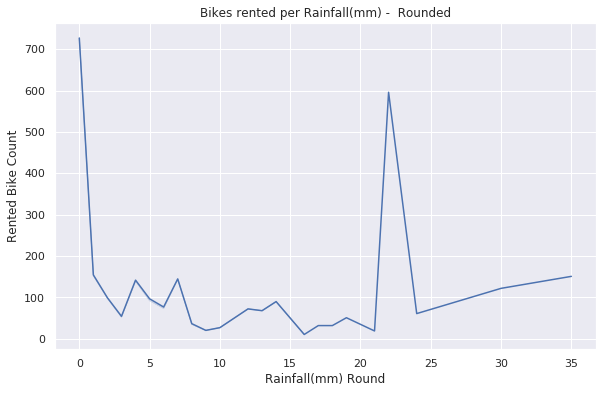

In [ ]:
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='Rainfall(mm) Round',y='Rented Bike Count',ci=False).set(title='Bikes rented per Rainfall(mm) -  Rounded')

Finally, we compare snowfall with demand. The conclusions we can draw are similar to those of rainfall.

[Text(0.5, 1.0, 'Bikes rented per Snowfall (cm)  -  Rounded')]

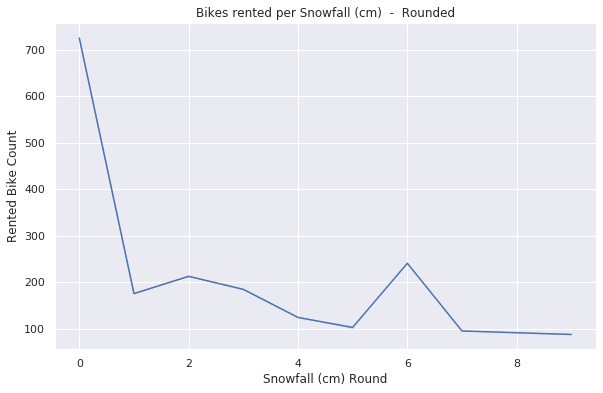

In [ ]:
plt.figure(figsize=(9.7,6))
sns.lineplot(data=data,x='Snowfall (cm) Round',y='Rented Bike Count',ci=False).set(title='Bikes rented per Snowfall (cm)  -  Rounded')

Next, we verify that most days have not had any rainfall or snowfall at all. These variables could be discretized, possibly providing clearer information in that case (we will study it).

In [ ]:
percentage_norain=(data[data["Rainfall(mm)"]==0].count()['Rainfall(mm)']/data.count()['Rainfall(mm)'])*100
percentage_nosnow=(data[data["Snowfall (cm)"]==0].count()['Snowfall (cm)']/data.count()['Snowfall (cm)'])*100
print("El {:.2f}% de días no ha llovido".format(percentage_norain))
print("El {:.2f}% de días no ha nevado".format(percentage_nosnow))

El 93.97% de días no ha llovido
El 94.94% de días no ha nevado


#### Categorical variables

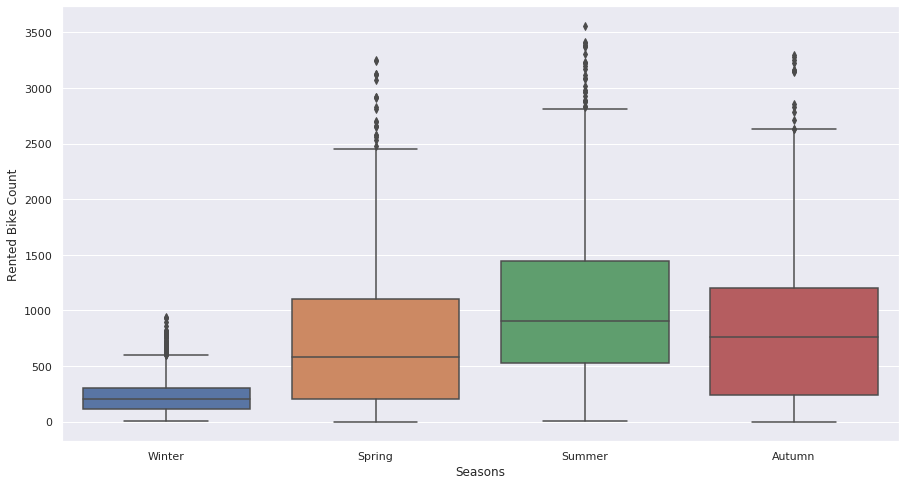

In [ ]:
# Boxplot comparing demand per season
sns.boxplot(data=data,x='Seasons',y='Rented Bike Count')

Above, it can be seen that summer is the season with the highest demand and winter the one with the lowest. It can also be seen that the ranges increase as the target variable increases, which is logical since even in those seasons demand can be minimal during the early morning (increasing variance), in addition to the fact that the presence of non-business days more significantly alters measures of central tendency and dispersion.

We verify that there are outliers in all four seasons, which we will analyze later.

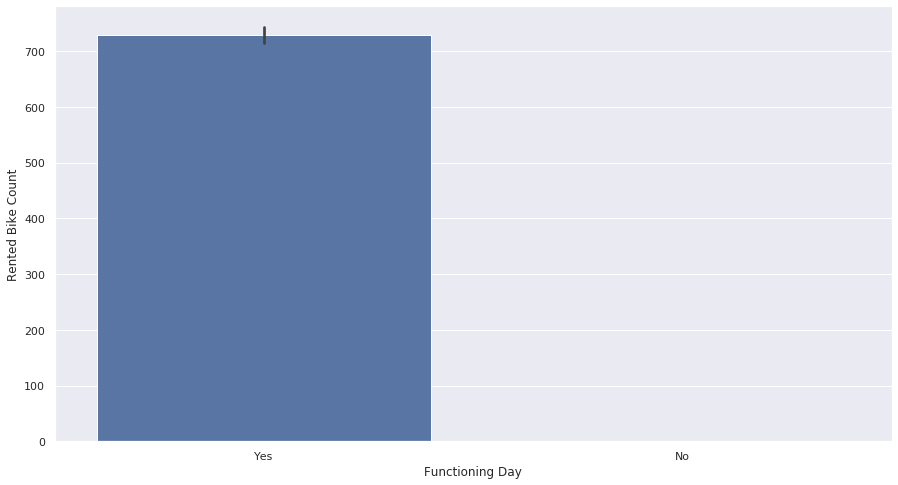

In [ ]:
# Gráfico de barras de demanda en función de día hábil / inhábil
sns.barplot(data=data,x='Functioning Day',y='Rented Bike Count')

In [ ]:
data.groupby('Functioning Day')['Functioning Day'].count()

Functioning Day
No      295
Yes    8465
Name: Functioning Day, dtype: int64

On non-business days, there is no demand at all.

This variable, and all the records with non-business days, could be eliminated. However, we will not perform this operation in order to make this work more comparable with others published. In any case, after testing our models, we have found that eliminating these records and the variable slightly worsens the results.

Below, we analyze how many business days there are according to the season:

In [ ]:
(data.groupby(['Seasons','Functioning Day'])['Functioning Day'].count()/data.groupby(['Seasons'])['Functioning Day'].count())*100

Seasons  Functioning Day
Autumn   No                  11.309524
         Yes                 88.690476
Spring   No                   2.173913
         Yes                 97.826087
Summer   Yes                100.000000
Winter   Yes                100.000000
Name: Functioning Day, dtype: float64

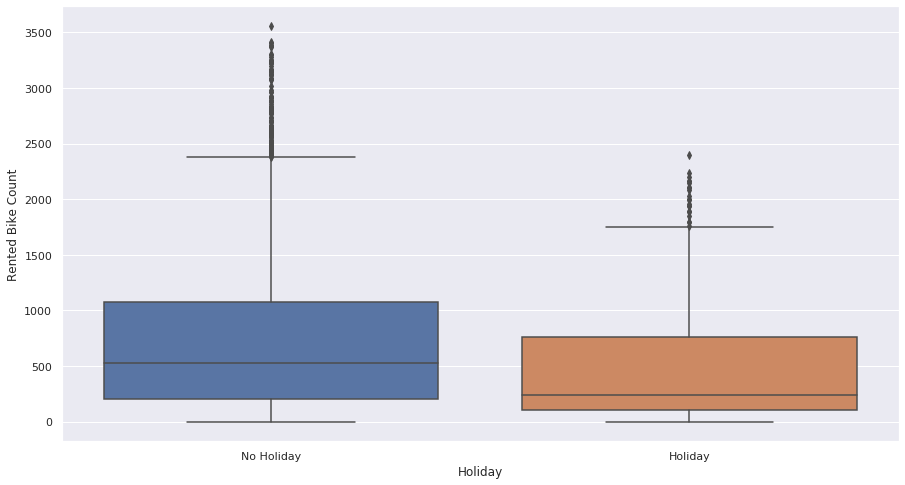

In [ ]:
# Boxplot of demand based on holidays/non-holidays days
sns.boxplot(data=data,x='Holiday',y='Rented Bike Count')

It is confirmed that demand is higher on non-holiday days. The existence of outliers is also anticipated, which we will check later.

Next, we see that holidays make up around 5% of the total days.

In [ ]:
data.groupby('Holiday')['Holiday'].count()

Holiday
Holiday        432
No Holiday    8328
Name: Holiday, dtype: int64

We count the percentage of holiday days based on the season. Surprisingly, winter has the most holidays and summer the least.

In [ ]:
(data.groupby(['Seasons','Holiday'])['Holiday'].count()/data.groupby(['Seasons'])['Holiday'].count())*100

Seasons  Holiday   
Autumn   Holiday        5.494505
         No Holiday    94.505495
Spring   Holiday        3.260870
         No Holiday    96.739130
Summer   Holiday        2.173913
         No Holiday    97.826087
Winter   Holiday        8.888889
         No Holiday    91.111111
Name: Holiday, dtype: float64

In [ ]:
# We remove the variables that we have rounded to make the graphs clearer.
eliminate=['TemperatureRound',
           'Dew point temperature Round',
           'Solar Radiation (MJ/m2) Round',
           'Visibility (10m) Round',
           'Rainfall(mm) Round',
           'Snowfall (cm) Round']

for i in eliminate:
  del data[i]

### Bivariate analysis

Next, the heatmap showing the correlations of the variables with each other is displayed.

I would like to highlight the negative correlation between humidity and visibility, as well as between humidity and solar radiation. The positive correlation between humidity and dew point temperature is also important.

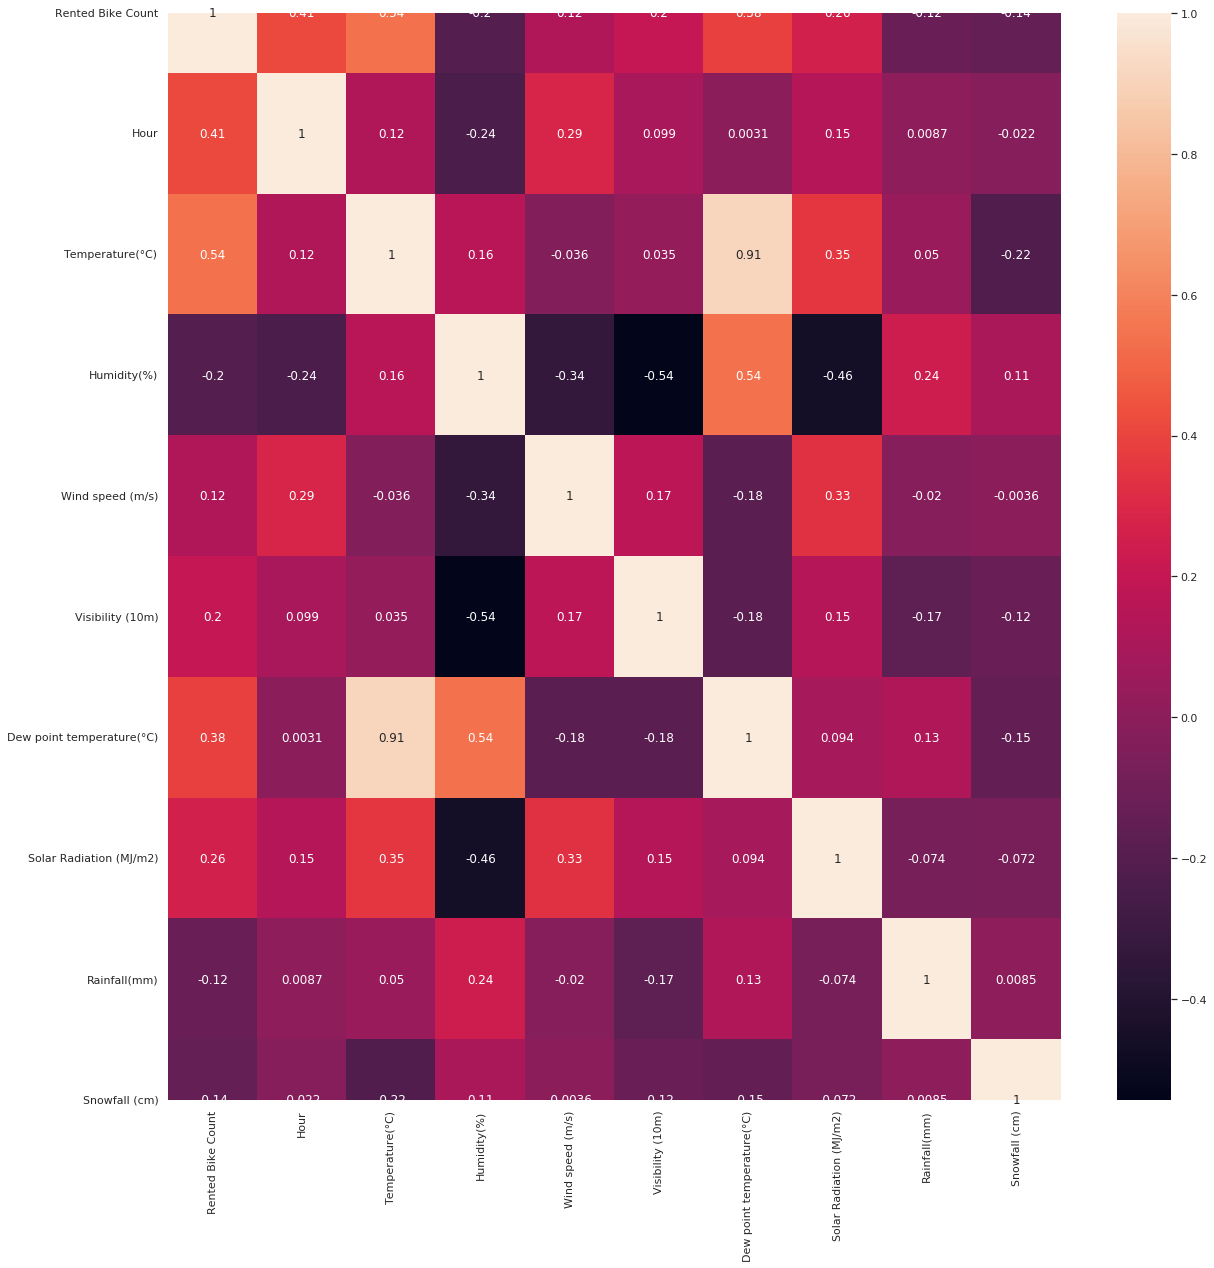

In [ ]:
# Heatmap showing the correlations of all variables with each other..
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),
            annot=True,
            )

# PREPROCESSING

In this phase, I will analyze the treatment of outliers, create and remove variables, transform categorical variables into dummies, and delve into the normalization and scaling phase of both dependent and independent variables, and data splitting.

### Outliers

In [ ]:
# Outliers in the target variable

outliers_bikes=data['Rented Bike Count'][(np.abs(stats.zscore(data['Rented Bike Count']))>3)].count()
print("Valores atípicos en la variable independiente: ",outliers_bikes)

Valores atípicos en la variable independiente:  67


We found a total of 67 outliers in the target variable. I will not treat these data as I consider them to be relatively few, and I believe that it is "dangerous" to alter the target variable without a compelling reason.

In [ ]:
# Outliers in independent variables

outliers_features={}
outliers_features['Humidity(%)']=data['Humidity(%)'][(np.abs(stats.zscore(data['Humidity(%)']))>3)].count()
outliers_features['Temperature(°C)']=data['Temperature(°C)'][(np.abs(stats.zscore(data['Temperature(°C)']))>3)].count()
outliers_features['Humidity(%)']=data['Humidity(%)'][(np.abs(stats.zscore(data['Humidity(%)']))>3)].count()
outliers_features['Wind speed (m/s)']=data['Wind speed (m/s)'][(np.abs(stats.zscore(data['Wind speed (m/s)']))>3)].count()
outliers_features['Visibility (10m)']=data['Visibility (10m)'][(np.abs(stats.zscore(data['Visibility (10m)']))>3)].count()
outliers_features['Dew point temperature(°C)']=data['Dew point temperature(°C)'][(np.abs(stats.zscore(data['Dew point temperature(°C)']))>3)].count()
outliers_features['Solar Radiation (MJ/m2)']=data['Solar Radiation (MJ/m2)'][(np.abs(stats.zscore(data['Solar Radiation (MJ/m2)']))>3)].count()
outliers_features['Rainfall(mm)']=data['Rainfall(mm)'][(np.abs(stats.zscore(data['Rainfall(mm)']))>3)].count()
outliers_features['Snowfall (cm)']=data['Snowfall (cm)'][(np.abs(stats.zscore(data['Snowfall (cm)']))>3)].count()
outliers_features
 

{'Humidity(%)': 0,
 'Temperature(°C)': 0,
 'Wind speed (m/s)': 63,
 'Visibility (10m)': 0,
 'Dew point temperature(°C)': 0,
 'Solar Radiation (MJ/m2)': 85,
 'Rainfall(mm)': 94,
 'Snowfall (cm)': 173}

Above, we found that there are 4 variables with outliers. Generally, they don't seem as excessively high figures, so I will not manipulate the records to correct them.

### Creación de variables

Next, I will extract the month and day of the week variables from the date variable.

In [ ]:
# Transform "Date" to datetime in order to extract the month and day of the week.
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
# Extraction of Month and Weekday
data['Month']=data['Date'].dt.month
data['Month']=data['Month'].astype('object')
data['DayofWeek']=data['Date'].dt.day_name()

Below, we can see that the day of the week variable appears to be significant, given the differences in demand based on it.

In [ ]:
# Demand per weekday
data.groupby('DayofWeek')['Rented Bike Count'].describe()

,count,mean,std,min,25%,50%,75%,max
DayofWeek,,,,,,,,
Friday,1224.0,734.449346,671.884755,0.0,189.0,547.0,1111.25,3380.0
Monday,1200.0,719.635833,675.368086,0.0,177.0,521.0,1087.50,3309.0
Saturday,1248.0,730.348558,632.484904,0.0,215.0,528.0,1099.50,3088.0
Sunday,1296.0,615.968364,602.075503,0.0,157.0,401.5,920.25,3256.0
Thursday,1248.0,743.803686,640.109054,2.0,234.5,579.0,1105.00,3418.0
Tuesday,1272.0,678.362421,625.244740,0.0,188.0,481.0,1032.25,3556.0
Wednesday,1272.0,714.521226,659.948601,0.0,198.0,495.5,1077.50,3384.0


I create a variable that captures whether the previous day was a holiday and another one that captures whether the next day will be a holiday. I do this using the "shift" function, collecting data from the 24 previous or subsequent records (thus attacking the day before or after at the same time).

In [ ]:
# Creation of the variables 
data['Holiday Previous']=data['Holiday'].shift(24)
data['Holiday Next']=data['Holiday'].shift(-24)

In [ ]:
# We fill in the empty variables (the first 24 in the "Holiday Previous" variable and the last 24 in the "Holiday Next" variable since they have no references.)
# We use the mode to fill in the empty variables (as we have seen, these fields will be filled with "non-holiday").
data['Holiday Previous']=data['Holiday Previous'].fillna(data['Holiday Previous'].mode()[0])
data['Holiday Next']=data['Holiday Next'].fillna(data['Holiday Next'].mode()[0])

Another novel variable that I add is the apparent temperature or thermal sensation.

To calculate this figure, I use the MetPy library, using the "apparent_temperature" function. The thermal sensation is usually calculated by meteorologists internationally through the Wind Chill Index or the Heat Index, based on various meteorological factors. When calling the "apparent_temperature" function, it automatically selects which of the two methods is more appropriate for calculating the result and applies it (both methods could be called separately, but it doesn't make sense when having such a wide range of temperatures).

In [ ]:
# Creation of thermal sensation variable
# Beforehand, we need to change the way Pandas understands arithmetic operations.
# To perform the calculation, we need to declare the units of measure of our dataset to MetPy so that it can perform the operation correctly.
pd.options.mode.chained_assignment = None
data['Apparent_Temperature']=metpy.calc.apparent_temperature(data['Temperature(°C)'].values*units.degC,data['Humidity(%)'].values*units.percent,data['Wind speed (m/s)'].values*units('m/s'),mask_undefined=False).to('degC')

As we have seen that in most hours, there is no rain or snow, and that when either of these variables takes a value above 0, demand drops significantly (without reducing excessively with intensity), I decided to try their discretization.

However, after testing the models, I found that the result worsens, so I decided to eliminate them.

I remove "Date" since I understand that it does not add value compared to the information already collected in month and day of the week.

In [ ]:
# Eliminamos lluvia tramificada, nieve tramificada (como explicamos arriba) y fecha
eliminate2=['Date']

for i in eliminate2:
  del data[i]

### Dummy variables creation

I transform the categorical variables into dummies. I carry out this process to generate the models.

In [ ]:
data=pd.get_dummies(data,drop_first=True)

Before continuing, I check the variables that our dataset contains, after the various modifications I have made.

In [ ]:
list(data)

['Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Apparent_Temperature',
 'Seasons_Spring',
 'Seasons_Summer',
 'Seasons_Winter',
 'Holiday_No Holiday',
 'Functioning Day_Yes',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',
 'DayofWeek_Monday',
 'DayofWeek_Saturday',
 'DayofWeek_Sunday',
 'DayofWeek_Thursday',
 'DayofWeek_Tuesday',
 'DayofWeek_Wednesday',
 'Holiday Previous_No Holiday',
 'Holiday Next_No Holiday']

### Normalization

#### Normalization of target variable

As we saw earlier, the distribution of the target variable is not normal. This fact usually harms the accuracy of the models, so I am going to correct it. (I understand accuracy in this work in a broad sense, not in the strict sense most applied to classification problems).

There are several techniques to transform the distribution into normal. Initially, I tried to do a Box-Cox transformation (below, I leave the commented code if the reader wants to try it), which is a very popular technique. Other tests were done using logarithms. However, the best results came after applying the square root to the target variable. This led to a distribution with less asymmetry than the one created by the Box-Cox transformation or the logarithm-based one.

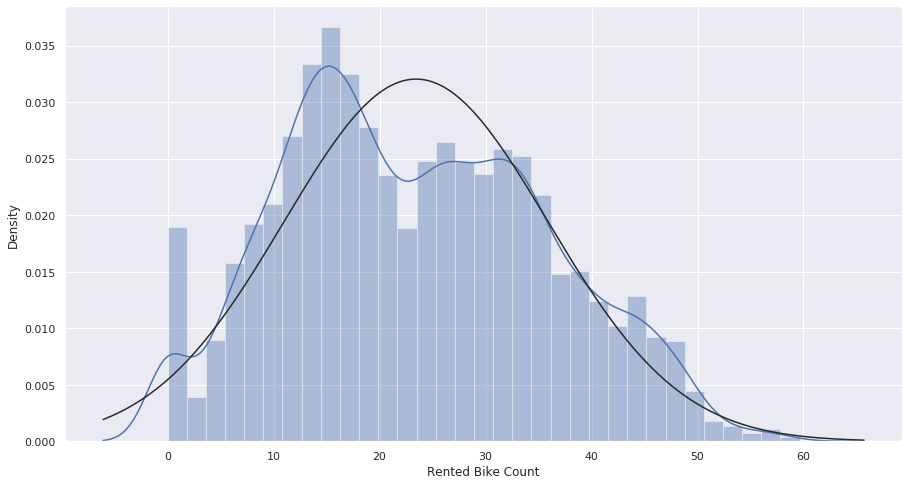

In [ ]:
# Immediately below, we show the commented code for the Box-Cox transformation.
#data['Rented Bike Count']=pd.Series(stats.boxcox(data['Rented Bike Count'], lmbda=0), name='Rented Bike Count')
#sns.distplot(data['Rented Bike Count'],fit=norm)

# Square root of target variable
data['Rented Bike Count']=np.sqrt(data['Rented Bike Count'])

# Graph showing the comparison of the transformed distribution and the normal distribution.
sns.distplot(data['Rented Bike Count'],fit=norm)

In [ ]:
# Calculamos asimetría y curtosis de la variable objetiva transformada
print("La asimetría es: ",data['Rented Bike Count'].skew())
print("La curtosis es: ",data['Rented Bike Count'].kurtosis())

La asimetría es:  0.237362090985412
La curtosis es:  -0.6572011997861553


As we can see above, the skewness has been reduced, from 1.15 to 0.23 (a much more acceptable figure), and the kurtosis becomes negative although its absolute value is reduced, from 0.85 to -0.65.

#### Split and feature standardization.

Prior to the modeling phase, I perform the data split into train and test sets. I allocate 20% of the data to the test set.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(data.drop('Rented Bike Count',axis=1),data['Rented Bike Count'],test_size=0.2,random_state=0)

Before moving on to the modeling phase, I standardize the features.

This process is important to improve the accuracy of the models, especially for Deep Learning models. Among the different scaling options provided by scikit-learn (MinMaxScaler, StandardScaler, and RobustScaler), I opt for RobustScaler. I do this because, as was previously shown, our dataset has outliers in several independent variables. Although I have considered that these values are controlled after studying them, I find it more appropriate to mitigate their effects in this way (I certainly prefer this option rather than removing them, and in any case, I am going to normalize the variables equally).

In [ ]:
# Implementation of RobustScaler
StdSclr=RobustScaler()

# We make sure that the variables keep their name and have a DataFrame format. I prefer this for interpreting the results while working on the model.
# x_train
x=x_train.values
x_scaled=StdSclr.fit_transform(x_train)
x_train_nocol=pd.DataFrame(x_scaled)
x_train_nocol.columns=x_train.columns
x_train=x_train_nocol
# x_test
x_test_scaled=StdSclr.transform(x_test)
x_test_nocol=pd.DataFrame(x_test_scaled)
x_test_nocol.columns=x_test.columns
x_test=x_test_nocol

# MODELING


## Tests with 9 models:

I proceed to create the models to predict results.

In total, I will try 9 models. They have been chosen not only for their effectiveness in this problem, as I have left out many that would offer good results. The goal of this phase is to apply techniques that have not been publicly applied to this dataset, showing how several of them offer very positive results.

Except for linear regression, which we will use as a benchmark for more traditional techniques, I have not found applications of the other techniques (excluding errors on my part).

The techniques we will use are:


*   "Traditional" techniques
1.   Linear Regression
2.   Huber Regression
3.   Stochastic Gradient Descent Regressor (SGD)

*   Boosting
4.   Catboost Regressor
5.   Extreme Gradient Boosting Random Forest Regressor (XGBRF)
6.   Light Gradient Boosting Machine Regressor (LGBM)

*   Deep Learning
7.   Multi-Layer Perceptron Regressor (MLP)
8.   Red neuronal densa
9.   Red neuronal convolucional (CNN)

It is worth highlighting the use of Deep Learning, as there are hardly any references to this dataset that apply it. There is also a scarcity of references to regression problems with 1 dimension that use a convolutional neural network. All these techniques will offer good results.






## "Traditional" techniques

Among these techniques, I include Multiple Linear Regression, Huber Regression, and Stochastic Gradient Descent Regressor (the latter is included in this section because it has been implemented since at least 1960, and it is also based on linear regressions).

The advantage of this block is that it offers greater interpretability, a positive element for a business team (for example, for a sales team that can push one variable or another as a lever).

The disadvantage is that it generally has lower accuracy compared to the rest of the techniques.

### Multiple Linear Regression

As we discussed earlier, this method has been widely used both in this dataset and in other similar datasets. However, I think it is relevant to use it to compare its results with the others.

Linear regression is a parametric technique (the number of coefficients is given from the beginning) that seeks to find the linear relationship between the dependent variable and a weighting of the independent variables, minimizing the mean squared error.

It is a simple model, well-known, and usually not as effective as Gradient Boosting or Deep Learning methods. However, its interpretability is very high. That is why even today it is still widely used in fields such as Econometrics, for example.

In [ ]:
# Creation of the model, training and testing
LR_model=LinearRegression(fit_intercept=True)
LR_model.fit(x_train,y_train)
LR_pred=LR_model.predict(x_test)

In [ ]:
# Calculation and printing of results
r2_lr=r2_score(y_test,LR_pred)
mse_lr=mean_squared_error(y_test,LR_pred)
rmse_lr=math.sqrt(mse_lr)
print("r2 =", r2_lr)
print("RMSE =", rmse_lr)

r2 = 0.6602577871268052
RMSE = 7.314692714706431


As we can see, the results are quite ordinary. We remind that the dependent variable has been subjected to a square root. This affects the interpretability of the RMSE, although not the coefficient of determination or r2.

Below we show a graph of the expected and actual results of the test set.

Text(0.3, 40, 'R2 = 0.66\nRMSE = 7.31')

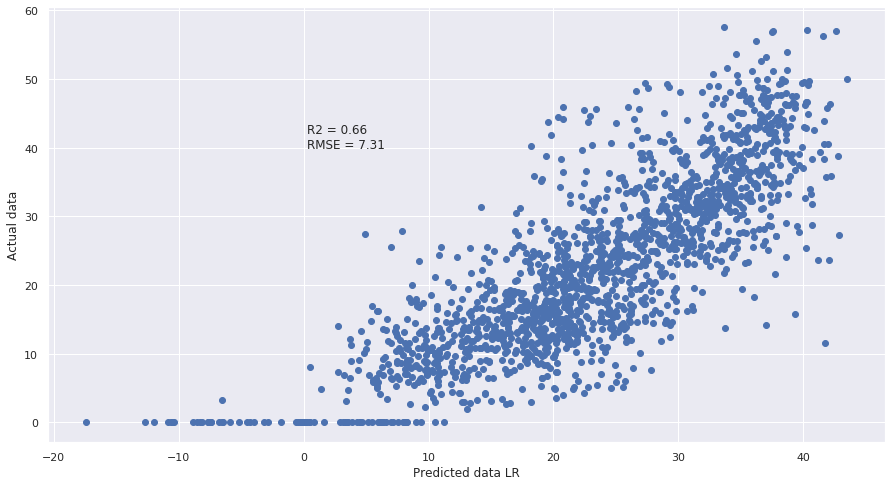

In [ ]:
# Printing expected and actual results from the test
plt.scatter(LR_pred,y_test)
plt.xlabel('Predicted data LR')
plt.ylabel('Actual data')
plt.text(0.3,40,"R2 = %0.2f" % r2_lr + '\n' "RMSE = %0.2f" % rmse_lr )

It is interesting to note in the upper graph how the Linear Regression fails to predict the results of non-working days (the 0s on the y-axis), predicting even negative values. We can identify these values as they are the only ones that actually take the value 0 in the initial dataset.

As we will see, the other models also make errors with these values. However, by removing them from the record (and doing the same with the variable), the results of almost all models worsen, so I will keep them.

### Hubber Regression

This technique is similar to Linear Regression. The difference is that it incorporates a loss function that penalizes the sum of the coefficients squared (L2 regularization). This leads to the regression being more robust against outliers.

In [ ]:
HR_model=HuberRegressor(fit_intercept=True,alpha=0.001,max_iter=3000)
HR_model.fit(x_train,y_train)
HR_pred=HR_model.predict(x_test)

In [ ]:
# Calculation and printing of results
r2_HR=r2_score(y_test,HR_pred)
mse_HR=mean_squared_error(y_test,HR_pred)
rmse_HR=math.sqrt(mse_HR)
print("r2 =",r2_HR)
print("RMSE =", rmse_HR)

r2 = 0.6583852972782276
RMSE = 7.3348224878612145


The results of this technique are similar to those of Linear Regression, which is not surprising given the similarities explained.

Text(0.3, 40, 'R2 = 0.66\nRMSE = 7.31')

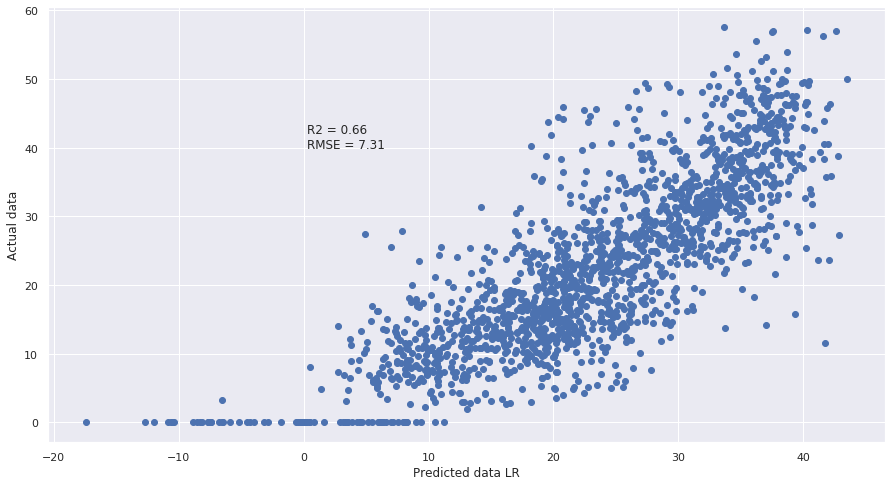

In [ ]:
# Printing test results
plt.scatter(LR_pred,y_test)
plt.xlabel('Predicted data LR')
plt.ylabel('Actual data')
plt.text(0.3,40,"R2 = %0.2f" % r2_lr + '\n' "RMSE = %0.2f" % rmse_lr )

### SGD Model

SGD models fit linear models by maximizing loss functions through stochastic gradient descent. The "stochastic" part of the model comes from the fact that in each iteration, random parts of the training data are chosen to be used in the model fit.

In [ ]:
SGD_model=SGDRegressor(shuffle=True,loss='squared_error')
SGD_model.fit(x_train,y_train)
SGD_pred=SGD_model.predict(x_test)

In [ ]:
# Calculation and printing of results
r2_SGD=r2_score(y_test,SGD_pred)
mse_SGD=mean_squared_error(y_test,SGD_pred)
rmse_SGD=math.sqrt(mse_SGD)
print("r2 =",r2_SGD)
print("RMSE =", rmse_SGD)

r2 = 0.6593858342170804
RMSE = 7.3240733277846735


As we can see, the results are similar to those of the previous two models.

Text(0.3, 40, 'R2 = 0.66\nRMSE = 7.32')

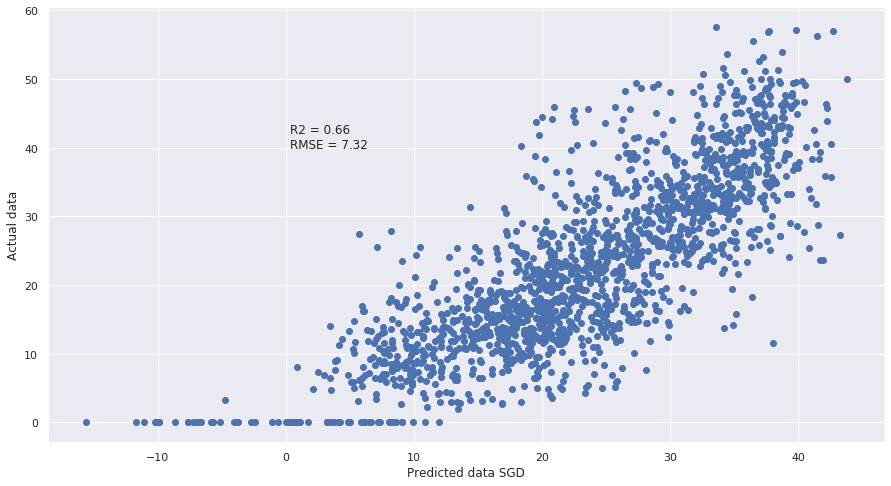

In [ ]:
# Printing of test results
plt.scatter(SGD_pred,y_test)
plt.xlabel('Predicted data SGD')
plt.ylabel('Actual data')
plt.text(0.3,40,"R2 = %0.2f" % r2_SGD + '\n' "RMSE = %0.2f" % rmse_SGD )

## Gradient Boosting

Gradient Boosting is a sequential training method for several models, based on decision trees. In this family, weak learners are transformed into strong ones. (Weak learners can be trees with one node and two leaves, for example, hence their reduced precision).

This technique is one of the most powerful in Machine Learning today, resulting in very low errors partly due to the ensemble method it is based on. It is sensitive to outliers, and can lead to overfitting, something we will try to control with cross-validation and which can also be prevented by applying regularization. Compared to models based on linear regressions, its interpretability is much lower.

### Catboost Regressor

This model incorporates symmetric prediction trees. It also allows working with categorical variables, although in our case it is not necessary since we have previously transformed them into dummies. Another advantage is that it offers good results even when the dataset size is not very large.


In [ ]:
catboost_model=cb.CatBoostRegressor(iterations=2,learning_rate=1,depth=10,loss_function='RMSE')

catboost_model.fit(x_train,y_train)
catboost_pred=catboost_model.predict(x_test)

0:	learn: 6.0063693	total: 70.5ms	remaining: 70.5ms
1:	learn: 4.9378788	total: 88.4ms	remaining: 0us


In [ ]:
# Calculation and printing of results
r2_catboost=r2_score(y_test,catboost_pred)
mse_catboost=mean_squared_error(y_test,catboost_pred)
rmse_catboost=math.sqrt(mse_catboost)
print("r2 =",r2_catboost)
print("RMSE =", rmse_catboost)

r2 = 0.8276269772452962
RMSE = 5.210219015741988


Results are already showing significant improvement compared to the previous techniques.

Text(0.3, 40, 'R2 = 0.83\nRMSE = 5.21')

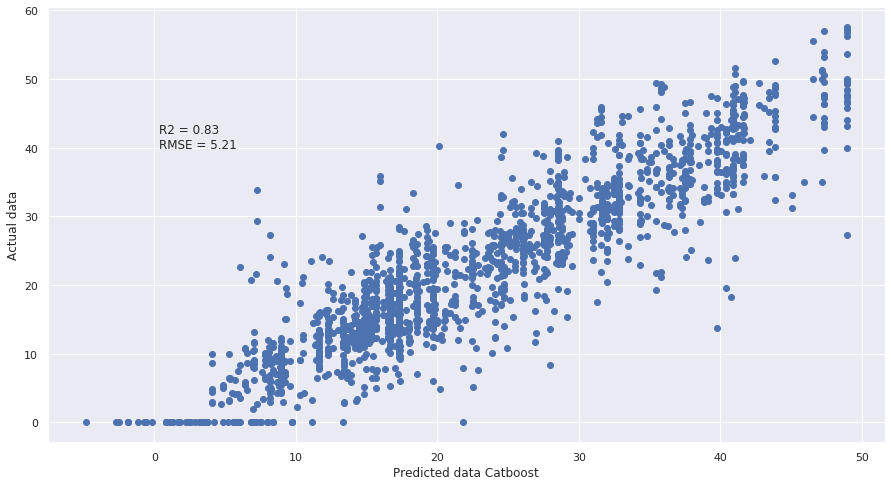

In [ ]:
# Printing of tests results
plt.scatter(catboost_pred,y_test)
plt.xlabel('Predicted data Catboost')
plt.ylabel('Actual data')
plt.text(0.3,40,"R2 = %0.2f" % r2_catboost + '\n' "RMSE = %0.2f" % rmse_catboost )

### XGBRF Regressor

This model is different from the Extreme Gradient Boosting Regressor (XGB Regressor). Specifically, it is a tool that combines techniques from XGB and Random Forest. I have not found any references to the application of XGBRF in the network with this dataset, and considering that the other two have been widely applied, I consider it interesting to implement this model to analyze differences with respect to these techniques applied separately.

In [ ]:
XGBRF_model=XGBRFRegressor(num_parallel_tree=40,num_boost_round=10,verbose=3,objective = "reg:squarederror")

XGBRF_model.fit(x_train,y_train)
XGBRF_pred=XGBRF_model.predict(x_test)

In [ ]:
# Calculation and printing of results
r2_XGBRF=r2_score(y_test,XGBRF_pred)
mse_XGBRF=mean_squared_error(y_test,XGBRF_pred)
rmse_XGBRF=math.sqrt(mse_XGBRF)
print("r2 =",r2_XGBRF)
print("RMSE =", rmse_XGBRF)

r2 = 0.6197186228599652
RMSE = 7.738804220295618


The results are quite ordinary, certainly worse than what has been seen in other works with the use of XGB and Random Forest.

Text(0.3, 40, 'R2 = 0.62\nRMSE = 7.74')

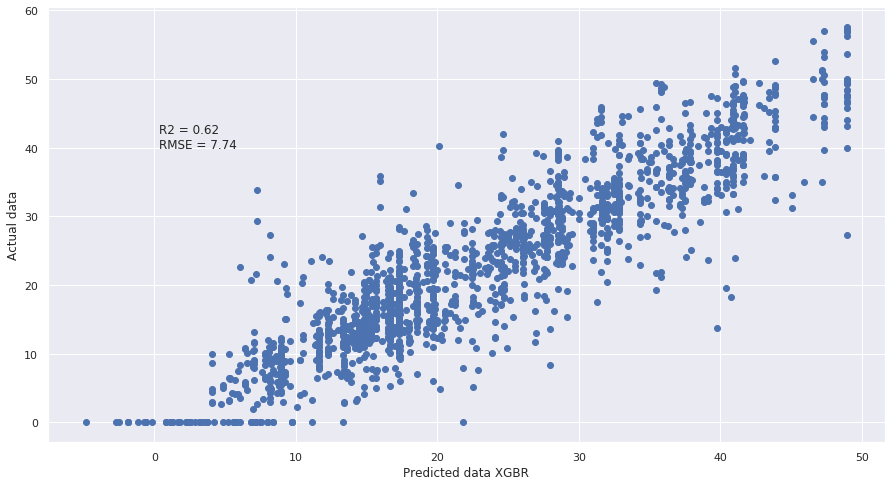

In [ ]:
# Printing test results
plt.scatter(catboost_pred,y_test)
plt.xlabel('Predicted data XGBR')
plt.ylabel('Actual data')
plt.text(0.3,40,"R2 = %0.2f" % r2_XGBRF + '\n' "RMSE = %0.2f" % rmse_XGBRF )

### LGBM Regressor

Light Gradient Boosting Machine (LGBM) is a technique that tends to achieve more accurate results while maintaining a more efficient and faster execution than XGBM. To achieve this, the model carries out smart featuring and smart sampling techniques, that is, it selects variables and parts of the dataset to train the model.

This technique runs a higher risk than other Gradient Boosting methods, for the reasons explained before, of leading to overfitting, which we will control with cross-validation later on.

In [ ]:
LGBMRegressor_model=LGBMRegressor(boosting_type='gbdt',n_estimators=100,num_leaves=30,max_depth=-1,learning_rate=0.1)

LGBMRegressor_model.fit(x_train,y_train)
LGBMRegressor_pred=LGBMRegressor_model.predict(x_test)

In [ ]:
# Calculation and printing of results
r2_LGBMRegressor=r2_score(y_test,LGBMRegressor_pred)
mse_LGBM=mean_squared_error(y_test,LGBMRegressor_pred)
rmse_LGBMRegressor=math.sqrt(mse_LGBM)
print("r2 =",r2_LGBMRegressor)
print("RMSE =", rmse_LGBMRegressor)

r2 = 0.923869708534057
RMSE = 3.462582080008891


The results are excellent, placing the model's performance above the average of the results published on the internet, and considering that we still intend to improve its accuracy.

Text(5, 47, 'R2 = 0.92\nRMSE = 3.46')

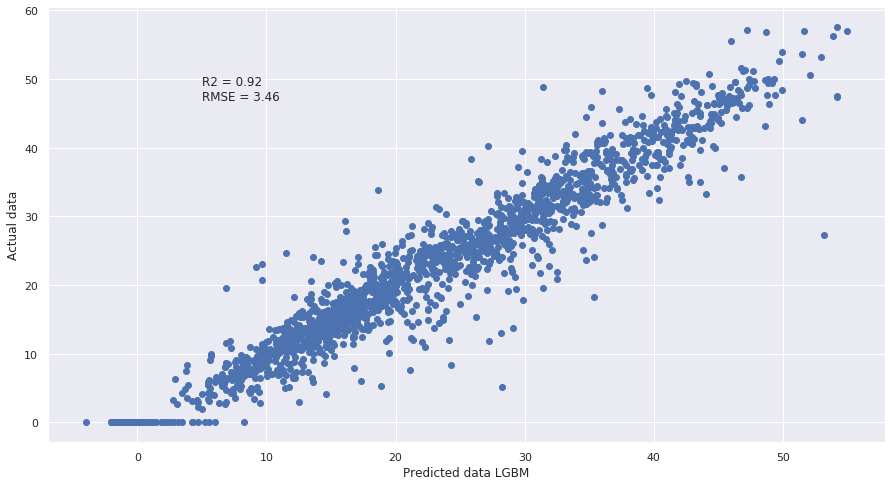

In [ ]:
# Printing of test results
plt.scatter(LGBMRegressor_pred,y_test)
plt.xlabel('Predicted data LGBM')
plt.ylabel('Actual data')
plt.text(5,47,"R2 = %0.2f" % r2_LGBMRegressor + '\n' "RMSE = %0.2f" % rmse_LGBMRegressor )

## Deep learning

We are now entering the Deep Learning block. In this block, we will see how the MLP regressor, a dense neural network, and a convolutional neural network perform.

In theory, neural networks are based on a similar scheme to that of the human brain, although such analogies are always hard to generalize.

Among their advantages are their accuracy, especially when dealing with large amounts of data. They are also highly recommended for unstructured data sets. Among their disadvantages, it could be highlighted that they are not at all interpretable for a business team (we could consider them a black box) and that they are very demanding in terms of computational power. In fact, this last point is what motivated me to use Google Colab, as it has a GPU with which to run the code.

As mentioned earlier, this is one of the main contributions, but also complexities, of this work.

### MLP Regressor

The Multi-Layer Perceptron Regressor is a Deep Learning method already integrated into the skicit-learn library. It is very flexible, and it is also easier to program and fine-tune than other neural networks.

In [ ]:
MLP_model=MLPRegressor(hidden_layer_sizes=(100,),learning_rate_init=0.01,learning_rate='constant',alpha=0.001,activation='relu',shuffle=True,verbose=False)

MLP_model.fit(x_train,y_train)
MLP_pred=MLP_model.predict(x_test)

In [ ]:
# Calculation and printing of results
r2_MLP=r2_score(y_test,MLP_pred)
mse_MLP=mean_squared_error(y_test,MLP_pred)
rmse_MLP=math.sqrt(mse_MLP)
print("r2 =",r2_MLP)
print("RMSE =", rmse_MLP)

r2 = 0.8951889593642803
RMSE = 4.062794420173349


Results are very positive too.

Text(5, 47, 'R2 = 0.90\nRMSE = 4.06')

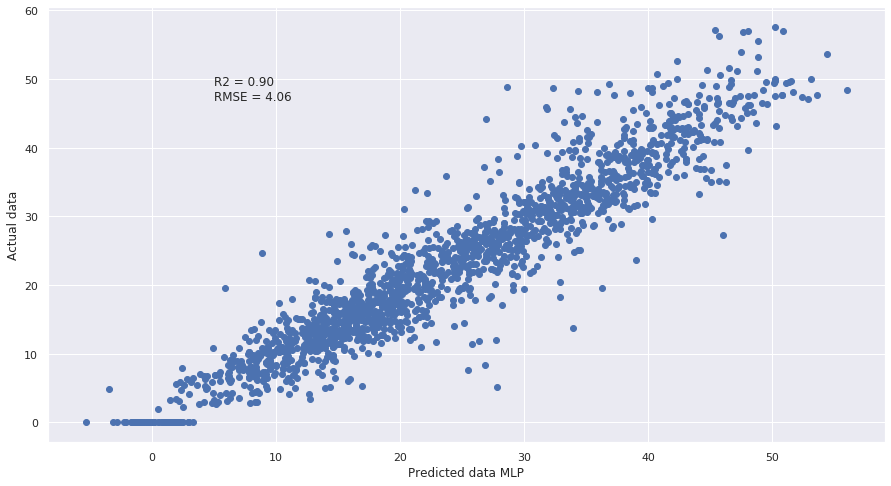

In [ ]:
# Imprimimos gráfico del resultado esperado y real del test
plt.scatter(MLP_pred,y_test)
plt.xlabel('Predicted data MLP')
plt.ylabel('Actual data')
plt.text(5,47,"R2 = %0.2f" % r2_MLP + '\n' "RMSE = %0.2f" % rmse_MLP )

### Dense Neural Network

Dense neural networks are powerful techniques that can achieve very good results, especially when dealing with large datasets.

Next, we will see how with a dense network we can achieve excellent results in this dataset.

In this case, I have created a network with four hidden layers and added earlystopping to prevent overfitting.

In [ ]:
# Network creation
modelDL=tf.keras.models.Sequential()
# First layer
modelDL.add(keras.layers.Dense(70,input_shape=(x_train.shape[1],),activation='relu'))
# Second layer
modelDL.add(keras.layers.Dense(50,activation='relu'))
# Third layer
modelDL.add(keras.layers.Dense(40,activation='relu'))
# Fourth layer
modelDL.add(keras.layers.Dense(30,activation='relu'))
# Output layer
modelDL.add(keras.layers.Dense(1,activation='linear'))

# Compilation
modelDL.compile(optimizer='adam',loss='mean_absolute_error', metrics=['mean_squared_error'])

Before continuing, let's examine the network.

In [ ]:
modelDL.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 50)                3550      
                                                                 
 dense_2 (Dense)             (None, 40)                2040      
                                                                 
 dense_3 (Dense)             (None, 30)                1230      
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 9,301
Trainable params: 9,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Early stopping adding to avoid overfitting

es1 = EarlyStopping(monitor='val_mean_squared_error', mode='min', verbose=1, patience=30)
historyDL=modelDL.fit(x_train,y_train,epochs=100,batch_size=16,validation_split=0.2,verbose=0,callbacks=es1)

Below we present a graph where it can be seen that the model does not exhibit a "strong" overfitting, in the sense that the error does not increase with the iterations. Although it is true that at a very early point it barely decreases. Since it does not increase, or even stop decreasing, we do not consider it to be an overfitting that needs to be reversed.

In [ ]:
# We print the keys of the dictionary we have created so that we can graphically present the history of the model.
print(historyDL.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


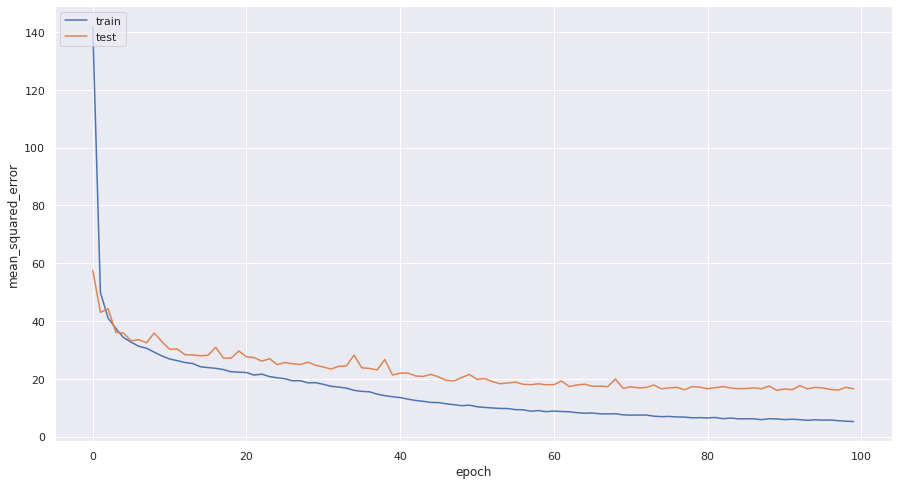

In [ ]:
# Graphical representation of the model 
plt.plot(historyDL.history['mean_squared_error'])
plt.plot(historyDL.history['val_mean_squared_error'])
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# Showing the results of the chosen metric 
resultsDL = modelDL.evaluate(x_test, y_test, verbose=1)

55/55 [==============================] - 0s 2ms/step - loss: 2.3900 - mean_squared_error: 13.5255


In [ ]:
# Calculation and printing of results 
DL_pred=modelDL.predict(x_test)
r2_DL=r2_score(y_test,DL_pred)
mse_DL=mean_squared_error(y_test,DL_pred)
rmse_DL=math.sqrt(mse_DL)
print("r2 =",r2_DL)
print("RMSE =", rmse_DL)

r2 = 0.9141163864028825
RMSE = 3.677701572760252


The results of the model are also excelent.



Text(5, 47, 'R2 = 0.91\nRMSE = 3.68')

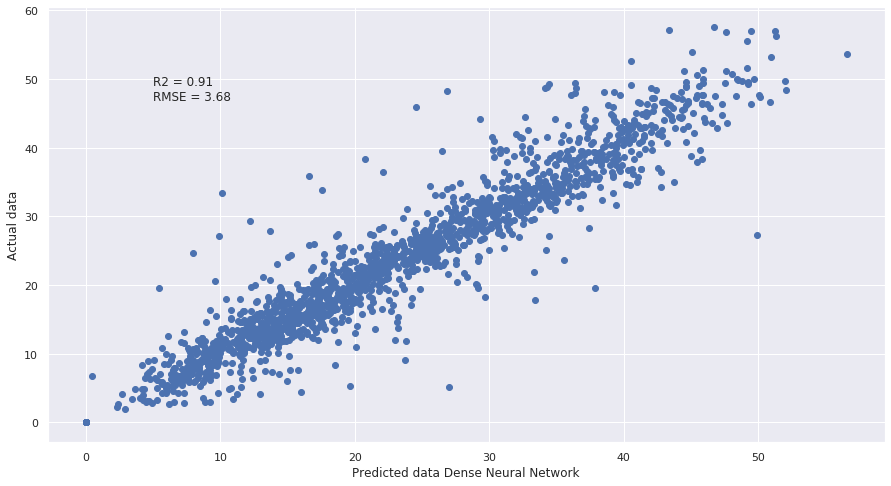

In [ ]:
# Printing test results
plt.scatter(DL_pred,y_test)
plt.xlabel('Predicted data Dense Neural Network')
plt.ylabel('Actual data')
plt.text(5,47,"R2 = %0.2f" % r2_DL + '\n' "RMSE = %0.2f" % rmse_DL )

### Convolutional Neural Network

The last model I have tested is a Convolutional Neural Network. These networks add filters, so they do not work with all the input data at once.

Not only have I not found any references to this type of model applied to this dataset, but it is also hardly used to solve this type of regression problems.

Convolutional Neural Networks are usually employed to deal with data with more dimensions, for example (but not only) for image processing.

However, considering that they are very complex and powerful models, we find it interesting to test their results for this dataset. To do this, a processing is needed to "create" a new dimension in the dataset. What I have done is to consider the records as one dimension, the features as another dimension, and finally, how many times each feature is repeated (i.e., 1) as the last dimension.

This type of processing is one of the most innovative contributions I have added to this work, in addition to the ones already mentioned.

In [ ]:
# Redimensioning of the dataset, setting input_dimension to 1, as explained above.
sample_size=x_train.shape[0]
time_steps=x_train.shape[1]
input_dimension=1

x_train_reshaped=x_train.values.reshape(sample_size,time_steps,input_dimension)

In [ ]:
# Network creation
modelCV=keras.Sequential(name='model_conv1D')
# Input layer
modelCV.add(keras.layers.Input(shape=(time_steps,input_dimension)))
# Layer
modelCV.add(keras.layers.Conv1D(filters=80,kernel_size=7,activation='relu',name='Conv1D_1'))
# Adding Dropout to prevent overfitting
modelCV.add(keras.layers.Dropout(0.3))
# Layers
modelCV.add(keras.layers.Conv1D(filters=64,kernel_size=3,activation='relu',name='Conv1D_2'))
modelCV.add(keras.layers.Conv1D(filters=64,kernel_size=2,activation='relu',name='Conv1D_3'))
# Adding MaxPooling to prevent overfitting
modelCV.add(keras.layers.MaxPooling1D(pool_size=3,name='MaxPooling1D'))
# Flatten layer
modelCV.add(keras.layers.Flatten())
# 2 Dense leyers
modelCV.add(keras.layers.Dense(32,activation='relu',name='Dense1'))
modelCV.add(keras.layers.Dense(input_dimension,name='Dense2'))
# Optimizer
optimizer=tf.keras.optimizers.RMSprop(0.001)

# Network Compilation
modelCV.compile(loss='mse',optimizer=optimizer,metrics=['mae'])

Before continuing, let's examine the model.

In [ ]:
modelCV.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 28, 80)            640       
                                                                 
 dropout_1 (Dropout)         (None, 28, 80)            0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 26, 64)            15424     
                                                                 
 Conv1D_3 (Conv1D)           (None, 25, 64)            8256      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 8, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 Dense1 (Dense)              (None, 32)               

In [ ]:
# Adding an early stopping to prevent overfitting
es2 = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=30)
historyCV=modelCV.fit(x_train_reshaped,y_train,epochs=100,validation_split=0.2,verbose=0,callbacks=es2)

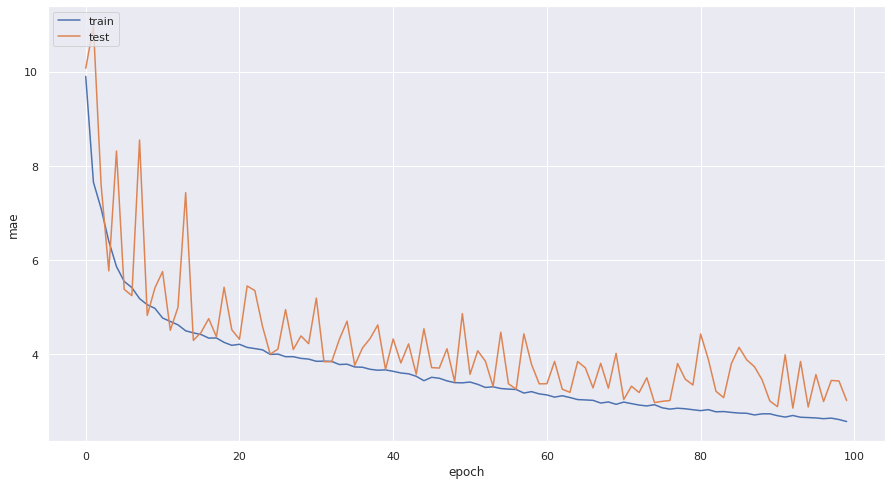

In [ ]:
# Graphic representation of model history
plt.plot(historyCV.history['mae'])
plt.plot(historyCV.history['val_mae'])
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


In [ ]:
# Data redimension for future model
x_test_reshaped=x_test.values.reshape(x_test.shape[0],x_test.shape[1],1)

In [ ]:
# Results of chosen metric
resultsCV = modelCV.evaluate(x_test_reshaped, y_test, verbose=1)

55/55 [==============================] - 0s 2ms/step - loss: 18.0270 - mae: 2.9448


In [ ]:
# Calculation and printing of results
CV1_pred=modelCV.predict(x_test_reshaped).flatten()
r2_CV1=r2_score(y_test,CV1_pred)
mse_CV1=mean_squared_error(y_test,CV1_pred)
rmse_CV1=math.sqrt(mse_CV1)
print("r2 =",r2_CV1)
print("RMSE =", rmse_CV1)

r2 = 0.8855329475807341
RMSE = 4.245820021579296


Text(5, 47, 'R2 = 0.89\nRMSE = 4.25')

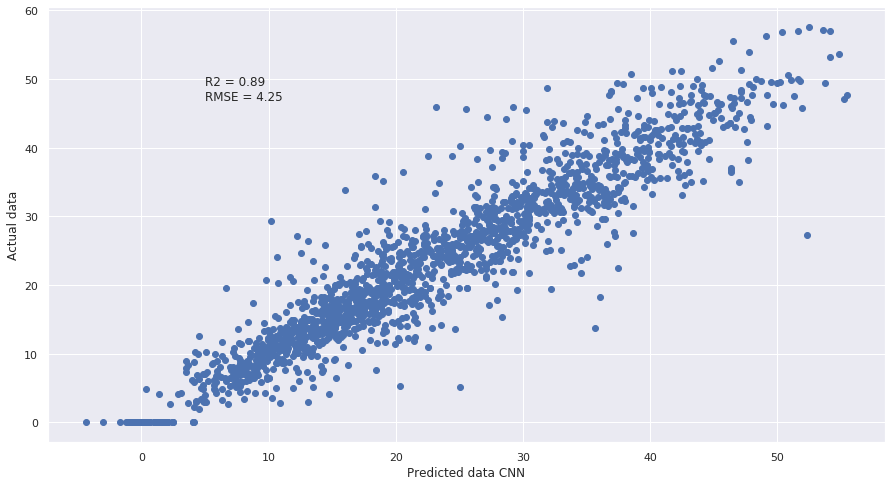

In [ ]:
# Printing of test results
plt.scatter(CV1_pred,y_test)
plt.xlabel('Predicted data CNN')
plt.ylabel('Actual data')
plt.text(5,47,"R2 = %0.2f" % r2_CV1 + '\n' "RMSE = %0.2f" % rmse_CV1 )

## Best models selections

#### Elimination of features

Once the test with the 9 models is completed, I select the top 3 models to improve them.

Usually, in this phase, only one model is selected to improve it. However, as one of the objectives of this work is to test and compare different techniques, I have selected 3: LGBM, MLP, and Dense Neural Network.

When it comes to eliminating variables, I will only analyze their importance for LGBM (being the best model so far), as we do not want to create 3 different datasets, one for each model.

In [ ]:
# Importance of features
# Dictionary creation in which the keys are the variables and the values are their importance.

importance={}
for i in range(len(x_train.columns)):
  importance[x_train.columns[i]]=[LGBMRegressor_model.feature_importances_[i]]

pd.DataFrame.from_dict(importance,orient='index',columns=['Variable Importance']).sort_values('Variable Importance',ascending=False)

,Variable Importance
Hour,555
Temperature(°C),299
Dew point temperature(°C),265
Humidity(%),252
Visibility (10m),198
Solar Radiation (MJ/m2),179
Wind speed (m/s),150
Apparent_Temperature,99
Rainfall(mm),96
Functioning Day_Yes,88


Above, we verified that the variables with less influence are the derivatives of "Holiday" and the dummies of "Month". On the other hand, the variable "Apparent_Temperature", which we created, obtains good results.

Finally, I only remove the variable "Holiday Previous_No Holiday", as after several tests I have confirmed that removing the other variables worsens the results of the models.

In [ ]:
# Scaling reversal 
# x_train
x_train_resc=StdSclr.inverse_transform(x_train)
x_train_resc_nocol=pd.DataFrame(x_train_resc)
x_train_resc_nocol.columns=x_train.columns
x_train=x_train_resc_nocol
# x_test
x_test_resc=StdSclr.inverse_transform(x_test)
x_test_resc_nocol=pd.DataFrame(x_test_resc)
x_test_resc_nocol.columns=x_test.columns
x_test=x_test_resc_nocol

In [ ]:
# Variables removal
eliminate=[#"Month_2", "Month_3", "Month_4", "Month_5", "Month_6", "Month_7", "Month_8", "Month_9", "Month_10", "Month_11", "Month_12",
           "Holiday Previous_No Holiday",
           #"Holiday Next_No Holiday"
           ]

for i in eliminate:
  del x_train[i]
  del x_test[i]

In [ ]:
# Rescaling data
# x_train
x=x_train.values
x_scaled=StdSclr.fit_transform(x_train)
x_train_nocol=pd.DataFrame(x_scaled)
x_train_nocol.columns=x_train.columns
x_train=x_train_nocol
# x_test
x_test_scaled=StdSclr.transform(x_test)
x_test_nocol=pd.DataFrame(x_test_scaled)
x_test_nocol.columns=x_test.columns
x_test=x_test_nocol

After removing the variables, we can check the results of the models.

In [ ]:
# LGBM new model building
LGBMRegressor_model_2=LGBMRegressor(boosting_type='gbdt',n_estimators=100,num_leaves=30,max_depth=-1,learning_rate=0.1)
LGBMRegressor_model_2.fit(x_train,y_train)
LGBMRegressor_2_pred=LGBMRegressor_model_2.predict(x_test)

In [ ]:
# Calculation and printing of results
r2_LGBMRegressor_2=r2_score(y_test,LGBMRegressor_2_pred)
mse_LGBM_2=mean_squared_error(y_test,LGBMRegressor_2_pred)
rmse_LGBMRegressor_2=math.sqrt(mse_LGBM_2)
print("r2 =",r2_LGBMRegressor_2)
print("RMSE =", rmse_LGBMRegressor_2)

r2 = 0.9235658767032583
RMSE = 3.469484687765973


In [ ]:
# MLP new model building
MLP_model_2=MLPRegressor(hidden_layer_sizes=(100,),learning_rate_init=0.01,learning_rate='constant',alpha=0.001,activation='relu',shuffle=True,verbose=False)
MLP_model_2.fit(x_train,y_train)
MLP_2_pred=MLP_model_2.predict(x_test)

In [ ]:
# Calculamos e imprimimos los resultados 
r2_MLP_2=r2_score(y_test,MLP_2_pred)
mse_MLP_2=mean_squared_error(y_test,MLP_2_pred)
rmse_MLP_2=math.sqrt(mse_MLP_2)
print("r2 =",r2_MLP_2)
print("RMSE =", rmse_MLP_2)

r2 = 0.9143047148400207
RMSE = 3.6736670667873894


In [ ]:
# New Dense Neural Network building
modelDL_2=tf.keras.models.Sequential()
modelDL_2.add(keras.layers.Dense(80,input_shape=(x_train.shape[1],),activation='relu'))
modelDL_2.add(keras.layers.Dense(60,activation='relu'))
modelDL_2.add(keras.layers.Dense(40,activation='relu'))
modelDL_2.add(keras.layers.Dense(30,activation='relu'))
modelDL_2.add(keras.layers.Dense(1,activation='linear'))

modelDL_2.compile(optimizer='adam',loss='mean_absolute_error', metrics=['mean_squared_error'])

In [ ]:
# Early Stopping to prevent overfitting
history2=modelDL_2.fit(x_train,y_train,epochs=100,batch_size=16,validation_split=0.2,verbose=0,callbacks=es1)

In [ ]:
# Calculation and priting of results
DL_2_pred=modelDL_2.predict(x_test)
r2_DL_2=r2_score(y_test,DL_pred)
mse_DL_2=mean_squared_error(y_test,DL_2_pred)
rmse_DL_2=math.sqrt(mse_DL)
print("r2 =",r2_DL_2)
print("RMSE =", rmse_DL_2)

r2 = 0.9141163864028825
RMSE = 3.677701572760252


#### Hyperparameters

Once the variables from the previous section are removed, I am going to tune the hyperparameters of the 3 selected models.

Initially, I am going to use GridSearchCV, as it performs this process by optimizing with cross-validation, so we can prevent and treat overfitting. For the neural network, as we will see, the process is somewhat more complex, as a similar technique is needed.

In [ ]:
grid_LGBM={
      'num_leaves':[50,75,100],
      'n_estimators':[300,400,500],
      'min_child_weight':[0,1e-2,1e-3],
      #'subsample':[1,0.9,1.1],
      #'reg_alpha':[0,0.5,1],  
      #'reg_lambda':[0,2,3],
      'learning_rate':[0.1,0.08], 
      'min_split_gain':[0,1,0.00001]      
}

Grid_LGBM=GridSearchCV(LGBMRegressor(),param_grid=grid_LGBM,verbose=1, cv=4, n_jobs=-1)

#Ejecutar cuando tengamos tiempo
Grid_LGBM.fit(x_train,y_train)

Fitting 4 folds for each of 162 candidates, totalling 648 fits


GridSearchCV(cv=4, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.08],
                         'min_child_weight': [0, 0.01, 0.001],
                         'min_split_gain': [0, 1, 1e-05],
                         'n_estimators': [300, 400, 500],
                         'num_leaves': [50, 75, 100]},
             verbose=1)

In [ ]:
# Extraction of best parameters and GridSearchCV score 
Grid_LGBM.best_params_, Grid_LGBM.best_score_

({'learning_rate': 0.08,
  'min_child_weight': 0,
  'min_split_gain': 0,
  'n_estimators': 500,
  'num_leaves': 50},
 0.932415450343381)

Updating hyperparamteres in LGBM model

In [ ]:
# New LGBM model building, updating hyperparameters
# After a few trials, I could confirm that 75 leaves improve the results
LGBMRegressor_model_3=LGBMRegressor(boosting_type='gbdt',n_estimators=500,num_leaves=75,max_depth=-1,learning_rate=0.08,min_child_weight=0)
LGBMRegressor_model_3.fit(x_train,y_train)
LGBMRegressor_3_pred=LGBMRegressor_model_3.predict(x_test)

In [ ]:
# Calculating and printing results
r2_LGBMRegressor_3=r2_score(y_test,LGBMRegressor_3_pred)
mse_LGBM_3=mean_squared_error(y_test,LGBMRegressor_3_pred)
rmse_LGBMRegressor_3=math.sqrt(mse_LGBM_3)
print("r2 =",r2_LGBMRegressor_3)
print("RMSE =", rmse_LGBMRegressor_3)

r2 = 0.9414741706842963
RMSE = 3.0359535251936367


As can be seen, the previous results have been improved thanks to this process.

Let's repeat the process with MLP model.

In [ ]:
# To decrease execution time, test size is reduced, not impacting the result in a significant way
grid_MLP={'hidden_layer_sizes':[(150,),(200,)],
          #'alpha': [0.01, 0.05, 0.1],
          'learning_rate_init':[0.01,0.1],
          'max_iter':[150,200,250],
          #'solver':['sgd','adam']
}
grid_MLP=GridSearchCV(MLPRegressor(),param_grid=grid_MLP,verbose=1, cv=4, n_jobs=-1)
grid_MLP.fit(x_train,y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


GridSearchCV(cv=4, estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(150,), (200,)],
                         'learning_rate_init': [0.01, 0.1],
                         'max_iter': [150, 200, 250]},
             verbose=1)

In [ ]:
# Extraction of best parameters and score of GridSearchCV
grid_MLP.best_params_, grid_MLP.best_score_

({'hidden_layer_sizes': (150,), 'learning_rate_init': 0.01, 'max_iter': 200},
 0.8957261947400781)

In [ ]:
# Building last version of the model, updating the hyperparameters
MLP_model_3=MLPRegressor(hidden_layer_sizes=(150,),max_iter= 200,learning_rate_init=0.01,learning_rate='constant',alpha=0.05,activation='relu',shuffle=True,verbose=False)
MLP_model_3.fit(x_train,y_train)
MLP_3_pred=MLP_model_3.predict(x_test)

In [ ]:
# Calculation and printing of results
r2_MLP_3=r2_score(y_test,MLP_3_pred)
mse_MLP_3=mean_squared_error(y_test,MLP_3_pred)
rmse_MLP_3=math.sqrt(mse_MLP_3)
print("r2 =",r2_MLP_3)
print("RMSE =", rmse_MLP_3)

r2 = 0.903971640237446
RMSE = 3.8888490536266613


Finally, I proceed to tune the hyperparameters of the dense neural network.

However, this phase is different from the previous models, as there is no function like GridSearchCV. The function I will use is RandomSearch, which will call a function to create the neural network that I have defined below. For this process, I have used keras_tuner. 

In [ ]:
# We define the function to create the neural networks
def build_model_DeepL(hp):
  modelDL_b=keras.models.Sequential()
  modelDL_b.add(keras.layers.Dense(hp.Choice('filters1',values=[90,80,70]),input_shape=(x_train.shape[1],),activation='relu'))
  modelDL_b.add(keras.layers.Dense(hp.Choice('filters2',values=[60,50,42]),activation='relu'))
  modelDL_b.add(keras.layers.Dense(hp.Choice('filters3',values=[50,40,32]),activation='relu'))
  modelDL_b.add(keras.layers.Dense(hp.Choice('filters4',values=[40,32,28]),activation='relu'))
  modelDL_b.add(keras.layers.Dense(1,activation='linear'))
  modelDL_b.compile(hp.Choice('optimizer',values=['adam','RMSprop']),loss='mean_squared_error', metrics=['mean_squared_error'])
  return modelDL_b

In [ ]:
# We define a function that applies RandomSearch, which calls the previous function
tuner2=keras_tuner.RandomSearch(
    build_model_DeepL,
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir2',
    overwrite=True,
)

In [ ]:
# We run the last function
tuner2.search(x_train,y_train,epochs=50,validation_data=(x_test,y_test))

Trial 5 Complete [00h 02m 02s]
val_mean_squared_error: 13.384084701538086

Best val_mean_squared_error So Far: 12.66083558400472
Total elapsed time: 00h 10m 32s


In [ ]:
# Summary of results
tuner2.results_summary()

Results summary
Results in my_dir2/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
filters1: 90
filters2: 50
filters3: 32
filters4: 28
optimizer: adam
Score: 12.66083558400472
Trial summary
Hyperparameters:
filters1: 70
filters2: 60
filters3: 32
filters4: 32
optimizer: RMSprop
Score: 13.200758616129557
Trial summary
Hyperparameters:
filters1: 90
filters2: 42
filters3: 32
filters4: 32
optimizer: RMSprop
Score: 13.384084701538086
Trial summary
Hyperparameters:
filters1: 90
filters2: 42
filters3: 40
filters4: 28
optimizer: adam
Score: 13.395530064900717
Trial summary
Hyperparameters:
filters1: 70
filters2: 42
filters3: 40
filters4: 32
optimizer: adam
Score: 13.420896848042807


In [ ]:
# Building of a neural network with best results from last exercise
modelDL_3=tf.keras.models.Sequential()
modelDL_3.add(keras.layers.Dense(90,input_shape=(x_train.shape[1],),activation='relu'))
modelDL_3.add(keras.layers.Dense(50,activation='relu'))
modelDL_3.add(keras.layers.Dense(32,activation='relu'))
modelDL_3.add(keras.layers.Dense(28,activation='relu'))
modelDL_3.add(keras.layers.Dense(1,activation='linear'))

modelDL_3.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])

In [ ]:
# Training of the network, applying early stopping
history_final=modelDL_3.fit(x_train,y_train,epochs=100,batch_size=16,validation_split=0.2,verbose=0,callbacks=es1)

In [ ]:
# Calculation and printing of results
DL_3_pred=modelDL_3.predict(x_test)
r2_DL_3=r2_score(y_test,DL_3_pred)
mse_DL_3=mean_squared_error(y_test,DL_3_pred)
rmse_DL_3=math.sqrt(mse_DL_3)
print("r2 =",r2_DL_3)
print("RMSE =", rmse_DL_3)

r2 = 0.9192559873825092
RMSE = 3.5659602264490173


Above, we verified how the results of the model have improved.

However, let us keep in mind that the RandomSearch function we have called does not optimize with cross-validation, so we cannot prevent and treat overfitting as with GridSearchCV. To illustrate this, below we show that there is not a serious "strong" overfitting (the result does not worsen, although there is a point where the improvement slows down).

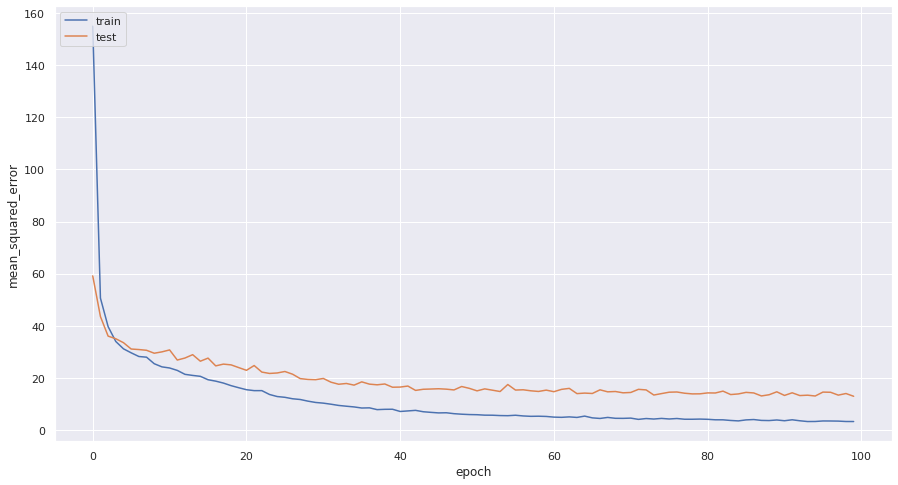

In [ ]:
# Graphical representation of results of the model
plt.plot(history_final.history['mean_squared_error'])
plt.plot(history_final.history['val_mean_squared_error'])
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# PRODUCTIVIZATION OF THE MODEL

#### Packaging of the model

Now that we have selected our best model, the 3rd version of LGBM, with excellent results, the last phase is to productize it.

First, I will generate a package with pickle, so that the model can be fed with new data, and even downloaded.

Next, I will create an interface that connects to an API I have established, allowing users to obtain results by adding inputs on a webpage. For this, I use ngrok.

In [ ]:
# Saving of the model in Pickle format
with open ('model1.pkl','wb') as p:
  pickle.dump(LGBMRegressor_model_3,p)

In [ ]:
# Opening of the Pickle file
with open ('model1.pkl','rb') as p:
  prediction=pickle.load(p)

Let's perform a test by adding data so that the model returns a prediction.

In this first test, I will pass the data and receive it without any processing, just as the model understands it.

In [ ]:
prediction.predict([[0.52,0.13,-0.15,1,0.66,0.61,2.12,0,0,0.41,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1]])

array([41.39672908])

We see above that the package responds perfectly. To improve interpretability, I will now perform a small process, by which both the independent and dependent variables are in the same format as in the initial CSV.

In [ ]:
# We check the list of variables before moving on
list(x_train)

['Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Apparent_Temperature',
 'Seasons_Spring',
 'Seasons_Summer',
 'Seasons_Winter',
 'Holiday_No Holiday',
 'Functioning Day_Yes',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',
 'DayofWeek_Monday',
 'DayofWeek_Saturday',
 'DayofWeek_Sunday',
 'DayofWeek_Thursday',
 'DayofWeek_Tuesday',
 'DayofWeek_Wednesday',
 'Holiday Next_No Holiday']

In [ ]:
# We check how it gives results without passing normalized data by applying transform with the last fed fit
# By squaring the response, we reverse the normalization of the target variable

array=[[10,20,60,3,1000,10,2,0,0,22,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]]
arrayDFtrans=pd.DataFrame(array)
arrayDFtrans.columns=x_train.columns
arrayDFtrans=StdSclr.transform(arrayDFtrans)
prediction.predict(arrayDFtrans)**2

array([711.06070717])

#### Interface creation

Next, let's create the page with the API so that the user has an interface to enter their data and receive a response.

This process cannot be done directly from the terminal or using Flask in an easy way, as we are working in Colab. Therefore, what I have done is to use ngrok to be able to lift the API and the page directly from here.

First, it is necessary to register at https://dashboard.ngrok.com/login. Secondly, it is necessary to paste the ngrok AuthToken in the cell below.

In [ ]:
# El token que aparece en el dashboard de la cuenta de ngrok se tiene que introducir en esta celda
# En mi caso he introducido el mío pero lo muestro vacío ahora por seguridad
port_no = 5000
ngrok.set_auth_token("introduce aqui el token"))

First, you need to follow all the steps marked in the explanation above, as well as create a "Templates" folder in "Content" to which the shared template can be uploaded. Finally, when the result is loaded, you need to click on the link "Access the bike prediction interface here". It is possible that Chrome recognizes the page as insecure, so you need to skip that warning and reload the page if necessary (40X error type).

In [ ]:
# It is necesary to create "templates" in content and add the template found in the Github repository

app = Flask(__name__,template_folder="/content/templates")
bootstrap=Bootstrap(app)
run_with_ngrok(app)
public_url =  ngrok.connect(port_no).public_url
model=pickle.load(open('model1.pkl','rb'))

# Creation of the APIs

@app.route("/")
def home():
    return render_template("template_miguelm_tfm.html")

@app.route("/getprediction",methods=['POST'])
def getprediction():
  # Recibimos, procesamos y enviamos resultado
  input=[float(x) for x in request.form.values()]
  final_input=[np.array(input)]
  final_input_DF=pd.DataFrame(final_input)
  final_input_DF.columns=x_train.columns
  input_transf=StdSclr.transform(final_input_DF)
  prediction=model.predict(input_transf)
  finalprediction=int(prediction)**2
  return render_template("template_miguelm_tfm.html",output='Predicted result is: {}'.format(finalprediction))
print(f"Access the bike prediction interface here -> {public_url}")
app.run()

Acceda a la interfaz de predicción de bicicletas aquí -> http://7707-34-90-241-105.ngrok.io
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7707-34-90-241-105.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [22/Sep/2022 03:12:25] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Sep/2022 03:12:26] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [22/Sep/2022 03:12:27] "POST /getprediction HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Sep/2022 03:12:30] "POST /getprediction HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Sep/2022 03:12:34] "POST /getprediction HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Sep/2022 03:12:34] "POST /getprediction HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Sep/2022 03:12:35] "POST /getprediction HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Sep/2022 03:12:35] "POST /getprediction HTTP/1.1" 200 -


# Conclusions

In conclusion, this study has successfully explored new approaches and models for predicting hourly bicycle demand in Seoul. Among the nine models tested, the Light Gradient Boosting Machine (LGBM) emerged as the top performer, delivering the most accurate predictions. Deep Learning techniques also demonstrated promising results, with our novel approach of utilizing a Convolutional Neural Network (CNN) showing competitive performance, even though it did not outperform the LGBM model.

This work has achieved its goal of experimenting with new models on this dataset, obtaining some of the best published results for the problem at hand. The introduction of novel variables to the analysis has further contributed to the improvement of the model's performance, highlighting the importance of feature engineering in the development of predictive models.

Overall, this study represents another contribution to the field of demand forecasting and urban planning, showcasing the application of advanced machine learning techniques to a real-world problem.

In [ ]:
# Variables importance

importance={}

for i in range(len(x_train.columns)):
  importance[x_train.columns[i]]=[LGBMRegressor_model_3.feature_importances_[i]]

pd.DataFrame.from_dict(importance,orient='index',columns=['Variable Importance']).sort_values('Variable Importance',ascending=False)

,Variable Importance
Dew point temperature(°C),4978
Visibility (10m),4686
Temperature(°C),4385
Humidity(%),4191
Hour,4135
Wind speed (m/s),3817
Solar Radiation (MJ/m2),3637
Apparent_Temperature,1553
Rainfall(mm),553
DayofWeek_Sunday,458


Finally, I share the graph of the final model. Like in previous examples, its precision stands out, and the points at 0 for non-working days also catch attention, as the model doesn't estimate them 100% accurately.

Text(5, 47, 'R2 = 0.94\nRMSE = 3.04')

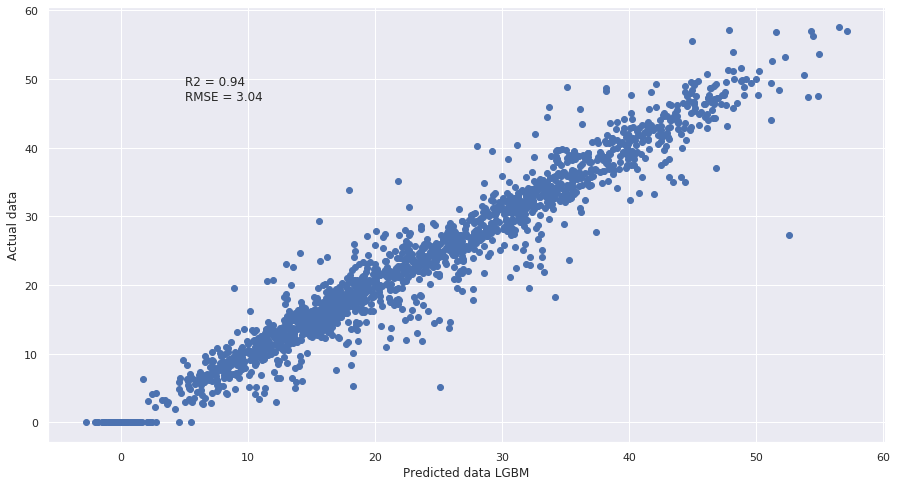

In [ ]:
plt.scatter(LGBMRegressor_3_pred,y_test)
plt.xlabel('Predicted data LGBM')
plt.ylabel('Actual data')
plt.text(5,47,"R2 = %0.2f" % r2_LGBMRegressor_3 + '\n' "RMSE = %0.2f" % rmse_LGBMRegressor_3 )

Thanks for reading.
Let me know if you have any comments on this work.